## Setup

In [25]:
from functions import Model, get99, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, drop_features, getCombinations, get_unique_list, bold, blue, red, green, getBestModel, np_to_df, df_to_np, drop99_all, z_score_individual, train_test_to_df, loadModel
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

warnings.filterwarnings('ignore')


## Testdata

Get Test Data from CSV

In [26]:
#Get test Data
NAME_TEST_FILE = "house_data_testing"
df_test_data = pd.read_csv("data/csv/"+NAME_TEST_FILE+".csv", sep=';') 

# remove unnamed column
df_test_data = df_test_data.iloc[:, 1:]

#Transform string to datetime
# try: 
#     df_test_data["date"] = pd.to_datetime(df_test_data["date"])
# except Exception as e:
#     print("Error: Trying to convert to date")

Drop Missing Values

In [27]:
print(f'There are {blue(df_test_data.isnull().sum().sum())} Missing Values')
df_test_data = dropMissingValues(df_test_data) 

There are 8 Missing Values


Drop Values with 999..99 

In [28]:
try:
    outlier_list_99 = get99(df_test_data) 
    df_test_data = drop99_all(df_test_data, outlier_list_99)
    print(green('99s dropped'), "\n")
except Exception as e:
    pass

99s dropped 



In [29]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 613
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             597 non-null    int64  
 1   date           597 non-null    object 
 2   price          597 non-null    float64
 3   bedrooms       597 non-null    int64  
 4   bathrooms      597 non-null    float64
 5   sqft_living    597 non-null    int64  
 6   sqft_lot       597 non-null    int64  
 7   floors         597 non-null    float64
 8   waterfront     597 non-null    float64
 9   dis_super      597 non-null    float64
 10  view           597 non-null    float64
 11  condition      597 non-null    float64
 12  grade          597 non-null    float64
 13  sqft_above     597 non-null    float64
 14  sqft_basement  597 non-null    float64
 15  yr_built       597 non-null    float64
 16  yr_renovated   597 non-null    int64  
 17  zipcode        597 non-null    int64  
 18  lat       

##

## Model

Get saved Model from Grid-Search

In [30]:
model_obj = loadModel()

Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 23


Making sure Shapes are similar

In [31]:
print(f'Training Data Features: {blue(len(model_obj.get_features()))}')
print(f'Testing Data Features: {blue(len(df_test_data.columns.to_list()))}')

features_to_drop = list(set(df_test_data.columns.to_list()) - set(model_obj.get_features()))
print(f'Features to drop from Testdata: {red(features_to_drop)}')

Training Data Features: 23
Testing Data Features: 25
Features to drop from Testdata: ['price', 'date']


Integrate test Data into Model

In [32]:
X_train, X_test, y_train, y_test = model_obj.get_data()

#Drop Features
X_test, y_test = df_test_data.drop(columns=features_to_drop), df_test_data["price"]

#Tranform Test-Data
if isinstance(model_obj.get_model(), Lasso) == True:
    scaler = StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)

model_obj.set_data(X_train, X_test, y_train, y_test)

#Train Model
model_obj.train()

#Predict
mae, score = model_obj.summary()
predictions = model_obj.pred()
print(bold("MAE: "), blue(mae))

MAE:  72151.81


In [33]:
#Evaluate
df_test_data["price_pred"]  = predictions
df_test_data["diff"] = df_test_data["price"]  - df_test_data["price_pred"]  
df_test_data.loc[:, ["price", "price_pred", "diff"]].T

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
price,336000.000000,1.600000e+06,460000.000000,998500.000000,745000.000000,325000.000000,810000.000000,677000.000000,600000.000000,412450.000000,...,473000.000000,343566.000000,550000.000000,387500.000000,500000.000000,739000.00000,710000.000000,475000.000000,340000.000000,475000.000000
price_pred,315324.875295,1.295648e+06,460749.622676,732822.749028,711554.174867,289639.558829,749123.525508,611437.518327,607773.528837,545745.344155,...,558119.697857,288119.248524,542953.680056,442539.549915,665955.291225,701865.22759,596984.356764,474855.451188,392743.644155,454203.146228
diff,20675.124705,3.043519e+05,-749.622676,265677.250972,33445.825133,35360.441171,60876.474492,65562.481673,-7773.528837,-133295.344155,...,-85119.697857,55446.751476,7046.319944,-55039.549915,-165955.291225,37134.77241,113015.643236,144.548812,-52743.644155,20796.853772


In [34]:
df_test_data.loc[:, ["price", "price_pred", "diff"]].describe().T

,count,mean,std,min,25%,50%,75%,max
price,597.0,524302.234506,320020.109169,17500.000000,332100.000000,465425.000000,625000.000000,2.950000e+06
price_pred,597.0,527039.768239,284494.794357,121478.956334,327764.839617,479994.104830,645638.532193,2.265743e+06
diff,597.0,-2737.533733,120916.447086,-556588.361121,-51117.074175,-6597.564171,39272.785235,1.072134e+06


Visulize Predictions

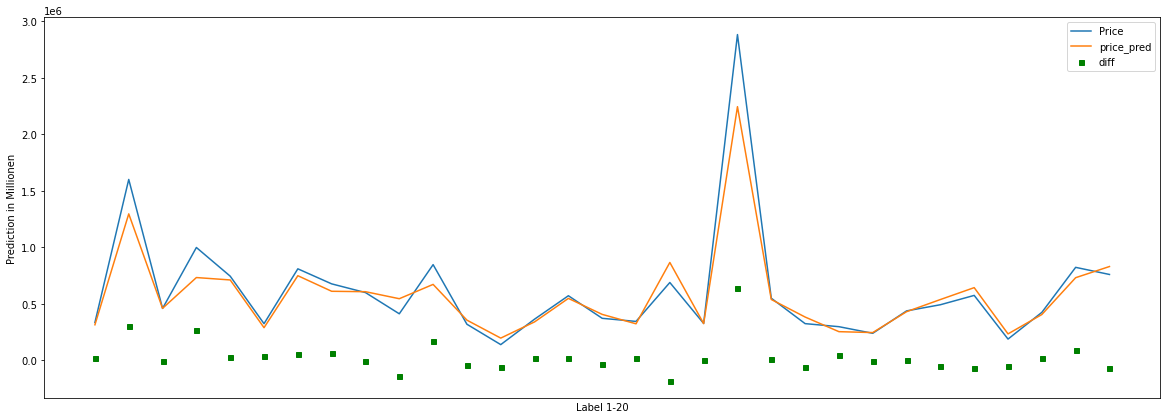

In [35]:
plt.figure(figsize=(20,7))
#Prediction der Modelle für die ersten 20 Zeilen
x = 30
real = df_test_data.loc[:x, "price"]
pred = df_test_data.loc[:x,"price_pred"]
diff = df_test_data.loc[:x,"diff"]

plt.plot(real, label="Price")
plt.plot(pred, label="price_pred")
plt.plot(diff, "gs", ms=5, label="diff")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Prediction in Millionen")
plt.xlabel("Label 1-20")
plt.legend(loc="best")

plt.show()